In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
from pathlib import Path
import csv
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
import keras
from keras.models import Sequential
from tensorflow import metrics
from sklearn.metrics import confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

**Step 1:**  
Convert audio files into PNG format images (or extracting the Spectrogram for every audio file)

In [2]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
# pathlib.Path(f'/image_data').
path = Path('Data/')
path_image = path / 'image_data'
path_image.mkdir(parents=True, exist_ok=True) 
path = Path('Data/Audio')
for file_name in os.listdir(path):
    file_path = f'Data/Audio/{file_name}'
    audio, sample_rate = librosa.core.load(file_path, mono=True)
    plt.specgram(audio, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
    plt.axis('off')
    plt.savefig(f'{path_image}/{file_name[:-3].replace(".", "")}.png')
    plt.clf()

<Figure size 576x576 with 0 Axes>

**Step 2:**     
Creating a header for the CSV file.

In [3]:
header = 'file_name chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' classified'
header = header.split()
# header

**Step 3:**   
Extracting features from Spectogram such as  Mel-frequency cepstral coefficients (MFCC), Spectral Centroid, Zero Crossing Rate, Chroma Frequencies, and Spectral Roll-off.

In [4]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    for file_name in os.listdir(path):
            file_path = f'Data/Audio/{file_name}'
            audio, sample_rate = librosa.load(file_path, mono=True)
            rms = librosa.feature.rms(y=audio)
            chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
            spec_cent = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
            spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
            rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
            zcr = librosa.feature.zero_crossing_rate(y=audio)
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate)
            to_append = f'{file_name} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += ' true' if 'not' not in file_name else ' false'
#             print()
#             print(to_append)
#             print()
            file = open('dataset.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

In [5]:
data = pd.read_csv('dataset.csv')
data = data.drop(data.index[0])
data = data.sample(frac=1)
# data.head(50)
data = data.drop(['file_name'],axis=1)

In [6]:
# data.dtypes

**Step 4:**  
Data preprocessing: It involves loading CSV data, label encoding, feature scaling and data split into training and test set.

In [7]:
#Encoding the Labels
hasFallen = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(hasFallen) #Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)) #Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Step 5:**    
Building an ANN model.

In [8]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Step 6:**   
Fit the model.

In [9]:
model.fit(X_train, y_train, epochs=100, batch_size=128)

Epoch 1/100
11/11 [==============================] - 1s 3ms/step - loss: 0.4778 - accuracy: 0.7421
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3400 - accuracy: 0.8725
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.2622 - accuracy: 0.9118
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2025 - accuracy: 0.9306
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1505 - accuracy: 0.9457
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1217 - accuracy: 0.9600
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0989 - accuracy: 0.9653
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.9744
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9751
Epoch 10/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0576 - accuracy: 0.9811
Epoch 11/

In [10]:

scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.77%


In [11]:
# joblib.dump(model,'trained_model.joblib')
model.save('trained_model')

INFO:tensorflow:Assets written to: trained_model\assets


In [12]:
ans = model.predict(X_test)

18/18 [==============================] - 0s 2ms/step


In [13]:
ans2 = np.zeros(len(ans))
for i in range(len(ans)):
#     print(ans[i][0], "---", ans[i][1])
    if ans[i][0] > ans[i][1]:
        ans2[i] = 0
    else:
        ans2[i] = 1

<AxesSubplot:>

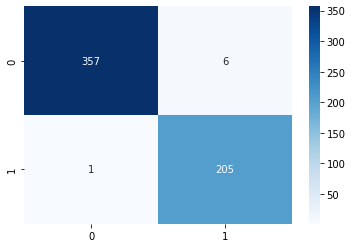

In [14]:
sns.heatmap(confusion_matrix(y_test, ans2), cmap = "Blues", annot=True, fmt = '.0f')

In [15]:
ans = model.predict(X_test)

18/18 [==============================] - 0s 3ms/step


In [16]:
ans2 = np.zeros(len(ans))
for i in range(len(ans)):
#     print(ans[i][0], "---", ans[i][1])
    if ans[i][0] > ans[i][1]:
        ans2[i] = 0
    else:
        ans2[i] = 1

<AxesSubplot:>

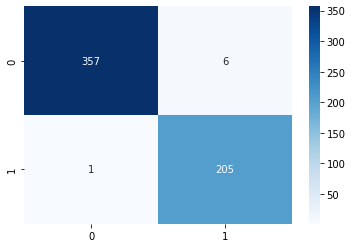

In [17]:
sns.heatmap(confusion_matrix(y_test, ans2), cmap = "Blues", annot=True, fmt = '.0f')

In [18]:
ans2 = np.zeros(len(ans))
for i in range(len(ans)):
#     print(ans[i][0], "---", ans[i][1])
    if ans[i][0] > ans[i][1]:
        ans2[i] = 0
    else:
        ans2[i] = 1

<AxesSubplot:>

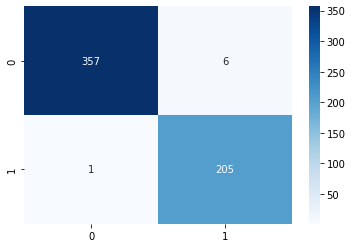

In [19]:
sns.heatmap(confusion_matrix(y_test, ans2), cmap = "Blues", annot=True, fmt = '.0f')